# Markov Chain Monte Carlo (MCMC)

Мотивирующий пример: кандидат в губернаторы объезжает города свого края с целью агитации. Каждый день для выбора следующего города он случайным образом намечает один из городов, соседних к текущему. Если число жителей в намеченном городе больше, чем в текущем, кандидат перемещается в намеченный город. В противном случае кандидат перемещается в намеченный город с вероятностью, равной отношению числа жителей этого города к числу жителей текущего, либо остается в текущем еще на один день. Проведя достаточно долгую агитационную кампанию выясняется, что доля времени, проведенная в каждом городе, пропорциональна числу жителей этого города. Убедимся в этом:

Задаем популяцию 15 городов случайными числами от 10 до 100:

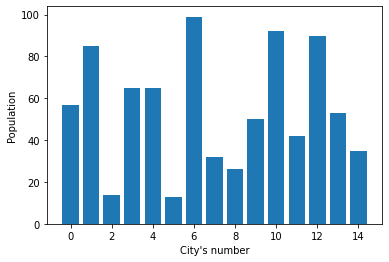

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cities = np.random.randint(10, 100, 15)

plt.bar(np.arange(len(cities)), cities)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Задаем функцию, которая определяет номер следующего города, куда отправляется кандитат (возможно, остается в текущем городе):

In [ ]:
def step(current, cities):
    direction = np.random.choice([-1, 1])
    target = (current + direction) % len(cities)
    ratio = cities[target] / cities[current]
    return target if np.random.rand() < ratio else current

Моделируем перемещения кандитата за период 10000 дней:

In [ ]:
walk = []
current = 1
for i in range(10000):
    current = step(current, cities)
    walk.append(current)

Рисуем гистограмму распределения доли времени, проведенного в каждом городе:

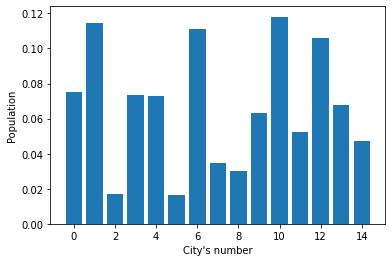

In [ ]:
plt.hist(walk, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Вывод: мы смогли достаточно точно оценить распределение числа жителей по городам, а выборка в массиве ```walk``` может быть использована как выборка из этого распределения!

Общая идея MCMC:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Алгоритм Metropolis sampling:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$
* пусть $Q = (q_{i, j})$ - матрица переходных вероятностей произвольной эргодической цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_i q_{i, j}}{\pi_j q_{j, i}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

In [ ]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

Прложение к предыдущей задаче:

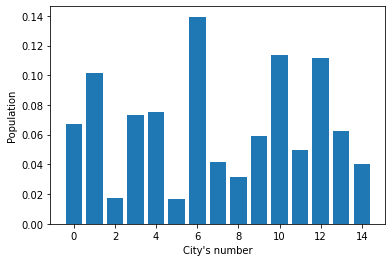

In [ ]:
value = lambda x: cities[x]
proposal = lambda x: (x + np.random.choice([-1, 1])) % len(cities)
post = metroplis(1, value, proposal, 10000)

plt.hist(post, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

## MCMC  в задаче байесовской оценки параметров

Байесовская оценка параметров при данном наблюдении (выборке) X выводится из известной формулы Байеса

$p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{\int p(X \ | \ \theta) p(\theta) \rm d\theta}$

Здесь
* $p(\theta)$ - prior
* $p(X \ | \ \theta)$ - likelihood
* $p(\theta \ | \ X)$ - posterior
* $p(X) = \int p(X \ | \ \theta) p(\theta) \rm d\theta$ - evidence or marginal likelihood

Разберем простейший пример, в котором оценка выводится аналитически, и сопоставим ее с численным расчетом по методу МСМС.

Будем подбрасывать монету, $\theta$ - неизвестный параметр успеха (вероятность выпадения орла). В качесте 
априорного распределения выберем бета-распределение $Beta(a, b)$. Напомним формулу для плотности вероятности $Beta(a, b)$:

$p(\theta) = \frac{1}{B(a, b)}\theta^{a-1}(1-\theta)^{b-1}$.

Функция правдоподобия в нашем случае:

$p(X \ | \ \theta) = C_N^X\theta^X(1-\theta)^{N-X}$.

Нетрудно убедиться, что $p(\theta \ | \ X) = Beta(X+a, N-X+b)$.

Построим график апостериорного распределения в предположении, что эксперимент с подбрасывание монеты N=100 раз завершился Х=61 успехом, а параметрами априорного распределения являлись a=b=10.
Отметим на графике точку, в которой достигается максимум апостериорной плотности. Такая точка называется оценкой МАР (maximum a posteriori). Для сравнения нарисуем график правдоподобия, соответствующий оценке максимального правдоподобия (MLE) ($\hat{\theta} = X/N)$.  


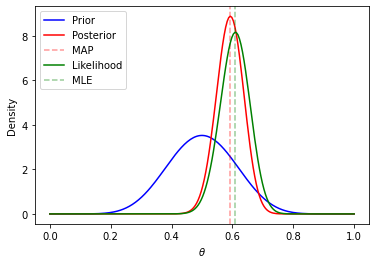

In [ ]:
from scipy import stats

a, b = 10, 10

N = 100
X = 61

prior = stats.beta(a, b)
post = stats.beta(X+a, N-X+b)
likelihood = lambda thetas: stats.binom(N, thetas).pmf(X)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.axvline((X + a - 1)/(N + a + b - 2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.axvline(X/N, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

Теперь представим, что мы оказались менее наблюдательными и не распознали в апостериорном распределении знакомой плотности. 
Тогда пришлось бы строить график апостериорной плотности по точкам. Для этого разобъем отрезок [0, 1], например, на 200 точек
thetas = np.linspace(0, 1, 200), для каждой точки вычислим значение правдоподобия и априоной плотности и (что гораздо хуже) вычислим и поделим  на нормировочный интеграл. Для приближенного вычисления нормировочного интеграла воспользуемся формулой прямоугольников, в одномерном случае это вполне решаемая задача. На картинке ниже график апостериорной плотности, построенный по точкам (красная линия), как это и должно быть, почти ничем не отличается от аналитического графика, приведенного на предыдущей картинке.

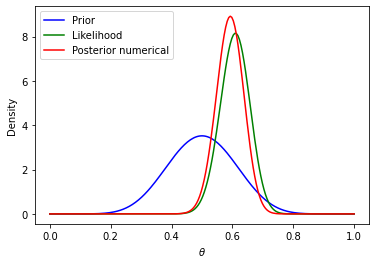

In [ ]:
thetas = np.linspace(0, 1, 200)

post = prior.pdf(thetas) * stats.binom(N, thetas).pmf(X)
post /= (post.sum() / len(thetas))

plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior numerical', c='red')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend()
plt.show()

Подведем промежуточный итог. В нашей задаче нам сильно повезло. Произведение биномиальной плотности правдоподобия и априорного бета-распределения по форме совпадает с бета-распределением (отсюда говорят, что бета является *сопряженным* априорным распределением к биномиальному):

$\theta^X(1-\theta)^{N-X} * \theta^{a-1}(1-\theta)^{b-1} = 
\theta^{X+a-1}(1-\theta)^{N-X+b-1}$

Нам даже не пришлось вычислять нормировочную константу (интеграл в знаменателе формулы Байеса), поскольку мы уже поняли, что в ответе должно быть бета-рспределение, а для него мы знаем нормировку. Но даже если бы мы всего этого не заметили, то, в силу малой размерности пространства параметров, нам не составило труда оценить апостериорную плотность по точкам.

Если хоть немного шагнуть в сторону от данного примера, то ситуация резко усложнится. Апостериорная плотность уже не будет никаким табличным распределением, а значит, придется вычислять нормировочный коэффициент, т.е.  интеграл в знаменателе. Вычислять, придется, конечно же, численно. В нашем примере пространство параметров (там, где живет $\theta$) одномерно и вполне можно попробовать обойтись формулой прямуогольников, перебирая все возможные $\theta$ по некоторой сетке. Но на практике гораздо чаще возникают задачи, когда пространство параметров существенно многомерно (10, 100, 1000 и т.д.). Здесь перебор станет проблемой. На помощь приходит МСМС.

## Metropolis sampler

Покажем, как метод МСМС помогает оценить апостериорную плотность. Из формулы Байеса следует, что апостериорная плотность с точностью до нормировочного коэффициента задается произведением правдоподобия на априорную плотность. Вот тут нам очень пригодится то, что для работы МСМС не требуется нормировка плотности! Поэтому забудем про интеграл в знаменателе. Теперь нужно решить, как задавать proposal - т.е. пробную точку для перехода на текущем шаге. Множество значений $\theta$ не дискретно, а непрерывно (отрезок [0, 1]), поэтому вместо матрицы переходных вероятностей потребуется указать переходную плотность. Один из способов задать переходную плотность - определить ее как N-мерное нормальное распределение с центром в текущей точке и некоторой фиксированной дисперсией (N совпадает с размерностью пространства параметров, в нашем случае N=1). Величина дисперсии является глобальным параметром и характеризует длину шага в пространстве параметров. 

Подготовим все необходимые функции:

In [ ]:
def value(theta, **kwargs):
    _ = kwargs
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(theta) * prior.pdf(theta)

In [ ]:
def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

Все готово, теперь зададим начальную точку х=0.2, величину шага будет характеризовать параметр sigma=0.1 и сделаем 3000 шагом по цепи Маркова: 

In [ ]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.1)

По полученному массива состояний построим гистограмму и сравним ее с точным аналитическим ответом (красная линия):

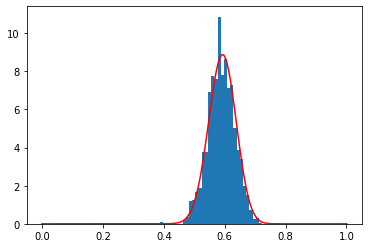

In [ ]:
plt.hist(post, bins=50, density=True, label='MCMC posterior')
plt.plot(thetas, stats.beta(X+a, N-X+b).pdf(np.linspace(0, 1, 200)),
         label='True posterior', c='red')
plt.show()

Мы видим, что выборочная гистограмма хорошо приближает искомую плотность. А это значит, что состояния ц.М. можно считать выборкой из искомой плотности.

Посмотрим, как выглядит траектория блуждания (напомним, стортовали из точки х=0.2). По горизонтальной оси - номер шага, по вертикали - сотояние. Траектория блуждания:

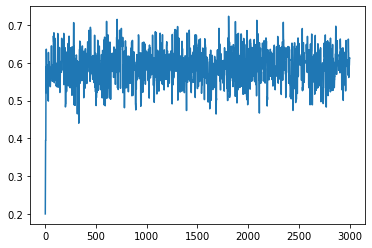

In [ ]:
plt.plot(post)
plt.show()

### Выбор ширины шага

Постомрим, как параметр sigma (характерная длина шага) сказывается на траектории:

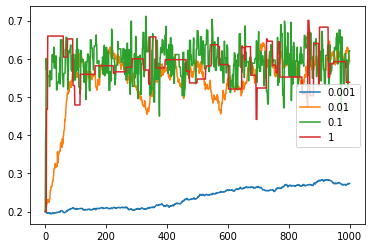

In [ ]:
for sigma in [0.001, 0.01, 0.1, 1]:
    post = metroplis(0.2, value, proposal, 1000, sigma=sigma)
    plt.plot(post, label=sigma)
plt.legend()
plt.show()

Вывод: шаг sigma=0.1 (зеленая траектория) оказался удачным выбором. С шагом sigma=0.001 мы бы еще долго шли в область, где сосредоточена искомая плотность, а с шагом 1 мы часто вылетаем за область допустимых значений параметра и в результате просто стоим на месте.


### Выбор начального приближения

Насколько влияем выбор начального состояния? Попробуем стартовать из разных точек отрезка [0, 1]:

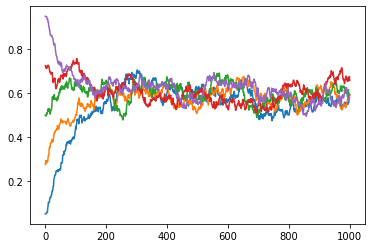

In [ ]:
for start in np.linspace(0.05, 0.95, 5):
    post = metroplis(start, value, proposal, 1000, sigma=0.01)
    plt.plot(post)
plt.show()

Вывод: при любом выборе начального состояния мы сходимся к целевому распределению, но нужно отбрасывать первые nbirn (например, 500) элементов выборки.

### Анализ корреляций

Нам бы хотелось получать выборку из независимых случайных величин, но понятно, что два соседних шага сильно связаны между собой. Посмотрим, через сколько шагом связь "забывается":

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


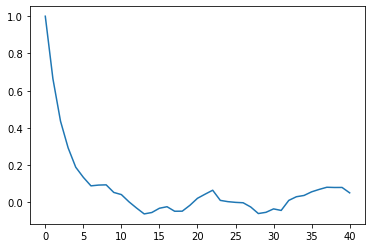

In [ ]:
from statsmodels.tsa import stattools

post = metroplis(0.2, value, proposal, 1000, sigma=0.1)

autocorr = stattools.acf(post[100:], fft=False)

plt.plot(autocorr)
plt.show()

Вывод: есть смысл прореживать выборку и брать элементы с шагом, например, 5.

### Проверка стационарности

Как проверить, что мы достигли стационарного состояния? Зарнее указать требуемое число шагов трудно, но, обладая куском ряда, можно проверить его на стационарность. Например, применив Gewerke test:

Разбиваем выборку на начальный и конечный куски $x_s$, $x_e$ и вычисляем статистику t-критерия Стьюдента для проверки совпадения параметров распределения в этих кусках. У стационарного ряда выборка, взятая в начале, не должна отличаться по статистическим свойствам от выборки, взятой в конце ряда:

In [ ]:
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

Проверим для sigma=0.1:

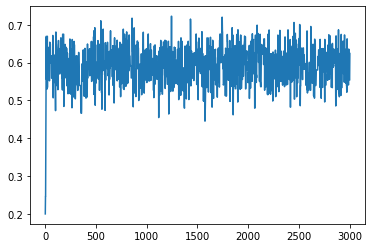

Ttest_indResult(statistic=-2.3756173276293207, pvalue=0.018016143388712113)

In [ ]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.1)
plt.plot(post)
plt.show()

g_test(post[100:])

Вывод: гипотезу стацинарности не отвергаем.

Проверим для sigma=0.01:

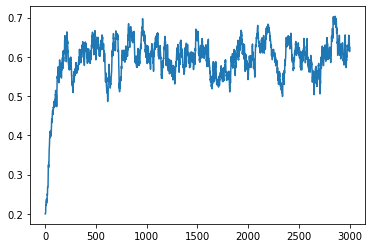

Ttest_indResult(statistic=-14.14140608399196, pvalue=1.8383094370506516e-35)

In [ ]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.01)
plt.plot(post)
plt.show()

g_test(post)

In [ ]:
g_test(post[1000:])

Ttest_indResult(statistic=1.0506669667446942, pvalue=0.2940376892589295)

Вывод: стационарность не подтверждается.


## Gibbs sampler

Для оценки набора парамеров $\theta = (\theta_1, \theta_2, ..., \theta_m)$ используем схему:

$\theta_i^{(t)} \sim p(\theta_i^{(t)}\ | \ \theta_1=\theta_1^{t}, ..., \theta_{i-1}=\theta_{i-1}^{t},
\theta_{i+1}=\theta_{i+1}^{t-1}, \theta_{m}=\theta_{m}^{t-1})$.

Пример: подбрасываем две монеты с параметрами $\theta_1$, $\theta_2$ и наблюдаем за числом успехов.

Зададим правдоподобия для одной монеты и для пары:

In [ ]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes for a single coin."""
    return theta**z * (1 - theta)**(N - z)

def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes for two coins."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

Вспомогательные методы для рисования графиков:

In [ ]:
def make_plots(X, Y, prior, likelihood, posterior):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
    ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
    ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.show()

thetas1 = np.linspace(0.05, 0.95, 100)
thetas2 = np.linspace(0.05, 0.95, 100)
X, Y = np.meshgrid(thetas1, thetas2)

Аналитические графики априорного распределение, правдоподобия и апостериорного распределения:

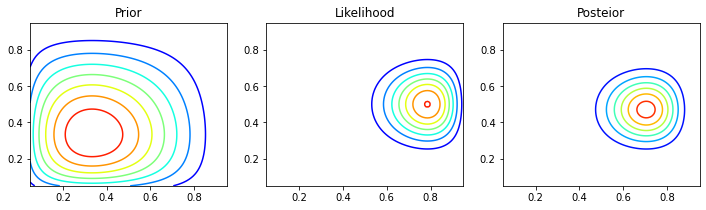

In [ ]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
likelihood = lambda theta1, theta2: bern2(theta1, theta2, z1=z1, z2=z2, N1=N1, N2=N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior)

Metropolis scheme:

In [ ]:
def value(theta, **kwargs):
    _ = kwargs
    theta1, theta2 = theta
    if theta1 < 0 or theta1 > 1:
        return 0
    if theta2 < 0 or theta2 > 1:
        return 0
    return likelihood(theta1, theta2) * prior(theta1, theta2)


def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

theta = np.array([0.2, 0.1])
niters = 5000
nburn = 200
sigma = np.diag([0.2, 0.2])

post = metroplis(theta, value, proposal, niter=niters,
                 nburn=0, sigma=np.array([0.1, 0.1]))

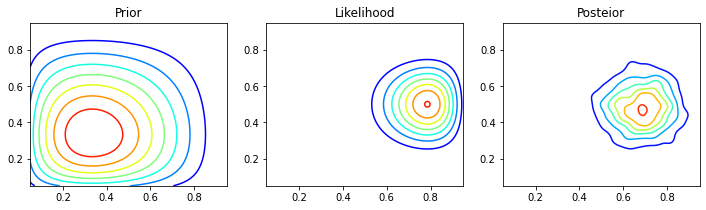

In [ ]:
kde = stats.gaussian_kde(np.array(post[nburn:]).T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior_metroplis)

Траектория блуждания на начальном этапе:


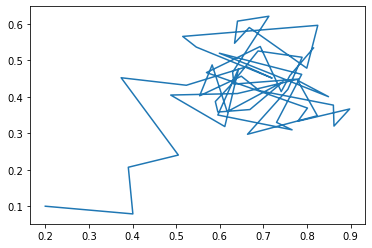

In [ ]:
plt.plot(*np.array(post[:100]).T)
plt.show()

Gibbs scheme:

In [ ]:
theta = np.array([0.2, 0.1])

post = [theta]
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]
    post.append(theta)

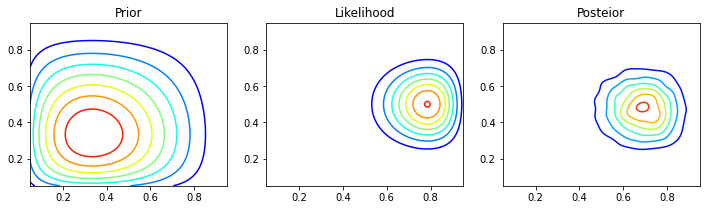

In [ ]:
kde = stats.gaussian_kde(np.array(post[nburn:]).T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior_gibbs)

Траектория блуждания на начальном этапе:

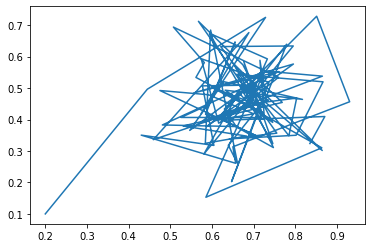

In [ ]:
plt.plot(*np.array(post[:100]).T)
plt.show()

Done!

## Домашнее задание

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа показан на картинке ниже (черные вершины имеют значение 1, белые - 0):

<!-- ![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg) -->

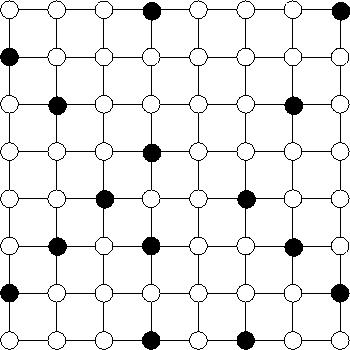

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чилел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi), \text{где $\xi \sim \mu$}
$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

## Задание

* Оценить  ${\rm E} n(\xi)$ с помощью МСМС для графа 8х8
* Обосновать численно и графически стационарность
* Построить график распределеиня $n(\xi)$
* Изобразить раскраску для одного из случайных графов, взятых из стационарного распределения.
* Дополнительная: построить график зависимости ${\rm E} n(\xi)$ от N - размера графа (NxN). Что можно сказать о скорости роста ${\rm E} n(\xi)$ как функции от N?

In [ ]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

Напишем функцию, которая определяет, допустимо ли стоят точки. Нужно описать и "центральные" точки, и "боковые", и "угловые". Это будет неприятно. Пусть когда все ок, она возвращает 0, когда не ок — минус 1.

In [ ]:
def prufen(G,x):    
    if (G[x[0]][x[1]] == 0):
        return 1
    if (x[0] > 0 and x[1] > 0 and x[0] < 7 and x[1] < 7):
        if (G[x[0]-1][x[1]] + G[x[0]][x[1]-1] + G[x[0]+1][x[1]] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if (x[0] == 0 and x[1] > 0 and x[0] < 7 and x[1] < 7):
        if (G[x[0]][x[1]-1] + G[x[0]+1][x[1]] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if (x[0] > 0 and x[1] == 0 and x[0] < 7 and x[1] < 7):
        if (G[x[0]-1][x[1]] + G[x[0]+1][x[1]] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if ( x[1] > 0 and x[0] == 7 and x[1] < 7):
        if (G[x[0]-1][x[1]] + G[x[0]][x[1]-1] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if (x[0] > 0 and x[1] > 0 and x[0] < 7 and x[1] == 7):
        if (G[x[0]-1][x[1]] + G[x[0]][x[1]-1] + G[x[0]+1][x[1]] == 0):
            return 0
        else:
            return -1
    if (x[0] == 0 and x[1] == 0 ):
        if ( G[x[0]+1][x[1]] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if (x[0] == 0  and x[1] == 7):
        if ( G[x[0]][x[1]-1] + G[x[0]+1][x[1]] == 0):
            return 0
        else:
            return -1
    if ( x[1] == 0 and x[0] == 7 ):
        if (G[x[0]-1][x[1]] + G[x[0]][x[1]+1] == 0):
            return 0
        else:
            return -1
    if ( x[0] == 7 and x[1] == 7):
        if (G[x[0]-1][x[1]] + G[x[0]][x[1]-1] == 0):
            return 0
        else:
            return -1

Теперь определим функцию проверки правильности всего графа.

In [ ]:
def richtig(G):
    for i in range (8):
        for j in range (8):
            if prufen(G,[i,j]) == -1:
                return 0
    return 1

Вычислим соседние графы.

In [ ]:
def nachbar(G):
    nachbarn = []
    kopieren = np.copy(G)
    for i in range (8):
        for j in range (8):
            if G[i][j] == 1:
                kopieren[i][j] = 0
                if (richtig(kopieren) == 1):
                    nachbarn.append(np.copy(kopieren))
                kopieren[i][j] = 1
            else:
                kopieren[i][j] = 1
                if (richtig(kopieren) == 1):
                    nachbarn.append(np.copy(kopieren))
                kopieren[i][j] = 0
    return nachbarn

Функция выбирающая соседнюю матрицу из случайных.

In [ ]:
def neueMatrix(G):
    N = nachbar(G)
    neueMat = random.choice(N)
    lange = len(N)
    return neueMat,lange

Теперь оформим переход от одной матрицы к соседней.

In [ ]:
def schritt(G):
    A,langeA = neueMatrix(G)
    B,langeB = neueMatrix(A)
    q = min(1,langeA/langeB)
    e = np.array([0,1])
    C = np.random.choice(e, p=[1-q,q])
    if C == 0:
        return G
    else:
        return A

Запустим нашу симуляцию.

15.1958


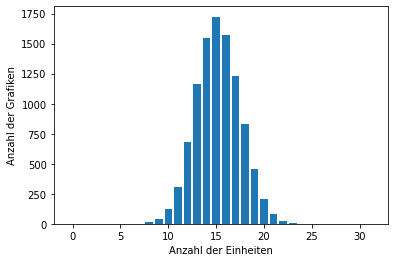

In [ ]:
gehen = []
for i in range (10000):
    X = schritt(X)
    su = np.sum(X)
    gehen.append(su.astype(int))
E = np.mean(gehen)
print(E)
plt.hist(gehen,bins = np.arange(33)-0.5, rwidth=0.8)
plt.xlabel('Anzahl der Einheiten')
plt.ylabel('Anzahl der Grafiken')
plt.show()

Препдположительно мат ожидание равно 15. Теперь разберемся с графиком распределения эн от кси.

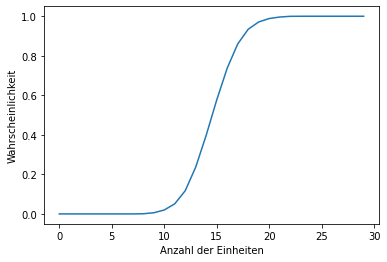

In [ ]:
new = np.zeros(30)
zahler = 0
for i in range (30):
    for j in range (5000):
        if i == gehen[j]:
            zahler += 1
    new[i] = zahler
ergebnis = np.zeros(30)
ergebnis[0] = new[0]
for i in range (1,30):
    ergebnis[i] = new[i]+ergebnis[i-1]
ergebnis = ergebnis.astype(int)
ergebnis = ergebnis/5000
plt.plot(np.arange(30).astype(int),ergebnis)
plt.xlabel('Anzahl der Einheiten')
plt.ylabel('Wahrscheinlichkeit')
plt.show()

Теперь проверим стационарность распределения.

<function matplotlib.pyplot.show>

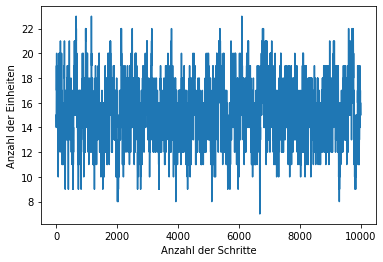

In [ ]:
plt.plot(gehen)
plt.ylabel('Anzahl der Einheiten')
plt.xlabel('Anzahl der Schritte')
plt.show

Видим, что реаспределение достаточно стационарная, вылетов за пределы нормальных значений по оси Y нет. Теперь изобразим раскраску одного из случайных графов.

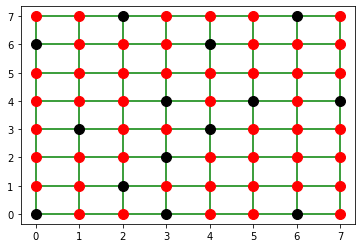

In [ ]:
x = []
y = []
for i in range (8):
    for j in range (8):
        if X[i][j] == 1:
            x.append(j)
            y.append(7-i)
xa = []
ya = []
for i in range (8):
    for j in range (8):
        if X[i][j] == 0:
            xa.append(j)
            ya.append(7-i)
plt.plot(np.arange(8),np.zeros(8),color='green')
plt.plot(np.arange(8),np.zeros(8)+1,color='green')
plt.plot(np.arange(8),np.zeros(8)+2,color='green')
plt.plot(np.arange(8),np.zeros(8)+3,color='green')
plt.plot(np.arange(8),np.zeros(8)+4,color='green')
plt.plot(np.arange(8),np.zeros(8)+5,color='green')
plt.plot(np.arange(8),np.zeros(8)+6,color='green')
plt.plot(np.arange(8),np.zeros(8)+7,color='green')
plt.plot(np.zeros(8),np.arange(8),color='green')
plt.plot(np.zeros(8)+1,np.arange(8),color='green')
plt.plot(np.zeros(8)+2,np.arange(8),color='green')
plt.plot(np.zeros(8)+3,np.arange(8),color='green')
plt.plot(np.zeros(8)+4,np.arange(8),color='green')
plt.plot(np.zeros(8)+5,np.arange(8),color='green')
plt.plot(np.zeros(8)+6,np.arange(8),color='green')
plt.plot(np.zeros(8)+7,np.arange(8),color='green')
plt.plot(xa,ya,'ro',ms=10,color='red')
plt.plot(x,y,'ro',ms=10,color='black')
plt.show()

Красные - это нолики, черные - единички

## Литература

*  http://probability.ca/jeff/ftpdir/johannes.pdf
* http://nitro.biosci.arizona.edu/courses/EEB596/handouts/Gibbs.pdf
